In [7]:
import csv

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [8]:
#dataset_joren = 'camara_data/hand_landmarks_joren_family.csv'
#dataset_joren_grandparents = 'camara_data/hand_landmarks_moeke.csv'
dataset_testGood = 'camera_data_test/hand_landmarks_goodTest.csv'
dataset_testBad = 'camera_data_test/hand_landmarks_badTest.csv'
dataset_testDark = 'camera_data_test/hand_landmarks_darkTest.csv'
model_save_path = 'new_hand_classifier.keras'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [9]:
NUM_CLASSES = 26

# Dataset reading

In [10]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1))))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data, axis=0)
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [11]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
y_dataset = np.concatenate(data, axis=0)
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))

In [12]:
print("X_dataset shape: " + X_dataset.shape.__str__())
print("y_dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X_test_dataset_good shape: " + X_testGood.shape.__str__())
print("y_test_dataset_good shape: " + y_testGood.shape.__str__())
print("----------------------------------")
print("X_test_dataset_bad shape: " + X_testBad.shape.__str__())
print("y_test_dataset_bad shape: " + y_testBad.shape.__str__())
print("----------------------------------")
print("X_test_dataset_dark shape: " + X_testDark.shape.__str__())
print("y_test_dataset_dark shape: " + y_testDark.shape.__str__())


X_dataset shape: (19200, 42)
y_dataset shape: (19200,)
----------------------------------
X_test_dataset_good shape: (2400, 42)
y_test_dataset_good shape: (2400,)
----------------------------------
X_test_dataset_bad shape: (2400, 42)
y_test_dataset_bad shape: (2400,)
----------------------------------
X_test_dataset_dark shape: (2400, 42)
y_test_dataset_dark shape: (2400,)


In [13]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [14]:
print(X_train)

[[ 0.          0.          0.18723404 ... -0.8808511  -0.12340426
  -1.        ]
 [ 0.          0.          0.09646302 ... -0.35369775  0.26688102
  -0.3215434 ]
 [ 0.          0.         -0.10497238 ...  0.5082873   0.44751382
   0.41436464]
 ...
 [ 0.          0.         -0.1130137  ...  0.68835616  0.46575344
   0.8458904 ]
 [ 0.          0.          0.16956522 ... -0.31304348 -0.05652174
  -0.25652173]
 [ 0.          0.          0.1691843  ... -0.6676737   0.23564954
  -0.6344411 ]]


# Model building

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = nan
Feature 1: Score = nan
Feature 2: Score = 2.3407979011535645
Feature 3: Score = 774.1659545898438
Feature 4: Score = 3.7496492862701416
Feature 5: Score = 899.2771606445312
Feature 6: Score = 5.4164838790893555
Feature 7: Score = 1002.3370361328125
Feature 8: Score = 5.917410850524902
Feature 9: Score = 1041.9844970703125
Feature 10: Score = 12.02907943725586
Feature 11: Score = 532.8719482421875
Feature 12: Score = 8.99458122253418
Feature 13: Score = 1036.7926025390625
Feature 14: Score = 7.895073890686035
Feature 15: Score = 1394.1888427734375
Feature 16: Score = 8.310308456420898
Feature 17: Score = 1816.0086669921875
Feature 18: Score = 19.303176879882812
Feature 19: Score = 505.4371643066406
Feature 20: Score = 12.042290687561035
Feature 21: Score = 1205.220458984375
Feature 22: Score = 6.4197773933410645
Feature 23: Score = 1708.598388671875
Feature 24: Score = 4.364501476287842
Feature 25: Score = 2216.578857421875
Feature 26: Score = 17.700498580932617
F

C:\thesis\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\thesis\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 21, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 2, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 2, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,618 (1.92 MB)

 Trainable params: 502,618 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [19]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [28]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9966 - loss: 0.0109
Epoch 1: saving model to new_hand_classifier.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9966 - loss: 0.0109 - val_accuracy: 0.9995 - val_loss: 0.0038
Epoch 2/1000
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9957 - loss: 0.0142
Epoch 2: saving model to new_hand_classifier.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9957 - loss: 0.0144 - val_accuracy: 0.9977 - val_loss: 0.0082
Epoch 3/1000
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9941 - loss: 0.0167
Epoch 3: saving model to new_hand_classifier.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9942 - loss: 0.0167 - val_accuracy: 0.9997 - val_loss: 0.0029
Epoch 4/1000
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9969 - loss: 0.0103
Epoch 4: saving model to new_hand_classifier.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9969 - loss: 0.0103 - val_accu

In [29]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0079


In [30]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testBad, y_testBad, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7715 - loss: 2.0791


In [31]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9058 - loss: 0.7543


In [24]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [25]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
[1.0000000e+00 9.7812991e-37 1.7915281e-30 6.4206699e-33 0.0000000e+00
 0.0000000e+00 9.5606743e-26 5.2522068e-25 1.0720125e-31 0.0000000e+00
 8.5022658e-20 5.6912263e-23 1.2526376e-28 2.2024749e-22 1.6962350e-32
 8.8022036e-17 1.8355570e-18 2.4906683e-32 1.8932688e-32 3.7529181e-13
 0.0000000e+00 1.3306994e-32 1.6537484e-22 2.9633857e-19 1.8877937e-18
 3.5090766e-36]
0


# Confusion matrix

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


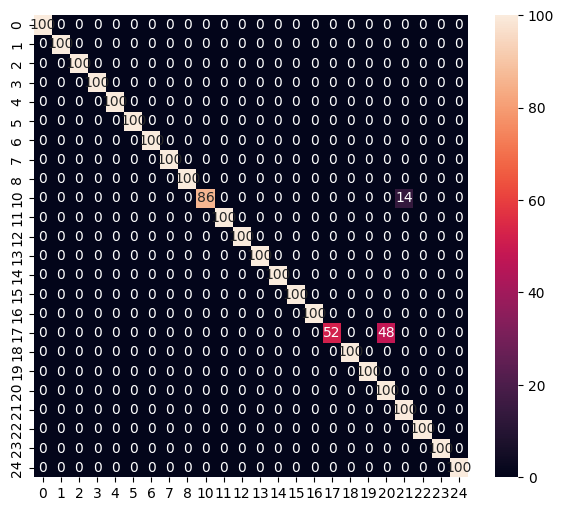

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
          10       1.00      0.86      0.92       100
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       1.00      1.00      1.00       100
          17       1.00      0.52      0.68       100
     

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [49]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpeyatuklo\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpeyatuklo\assets


# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_testGood[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

In [ ]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

#### Loss  (cost)

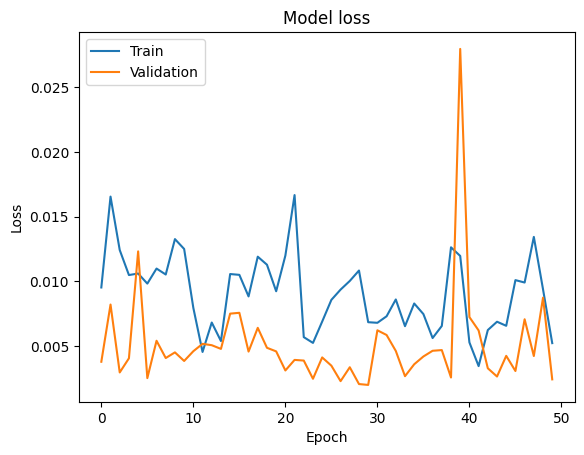

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

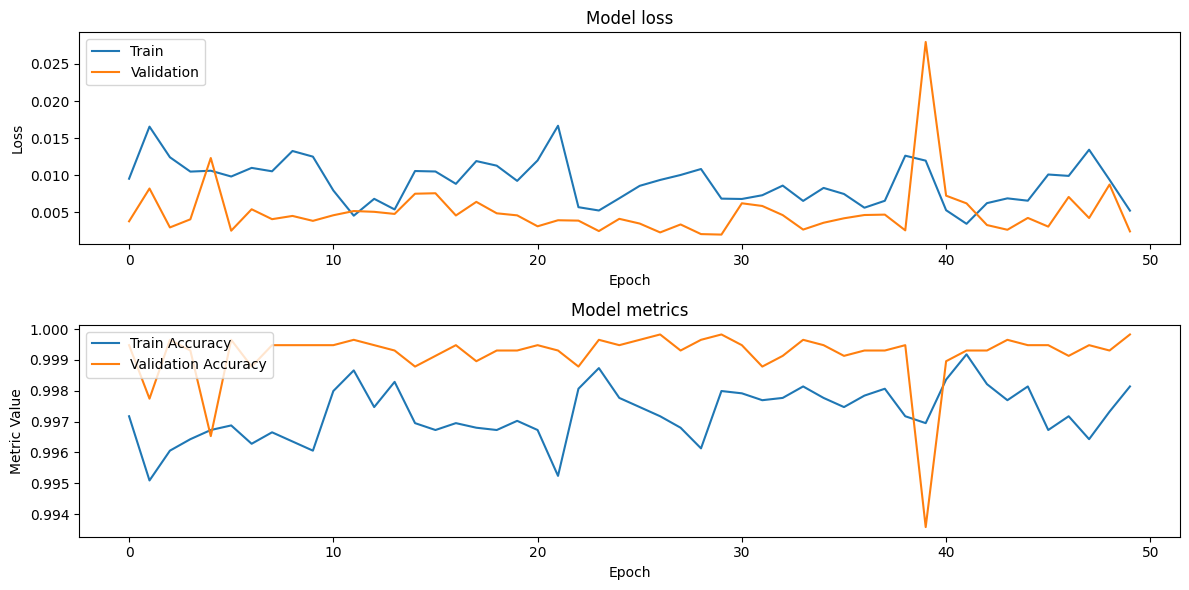

In [33]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

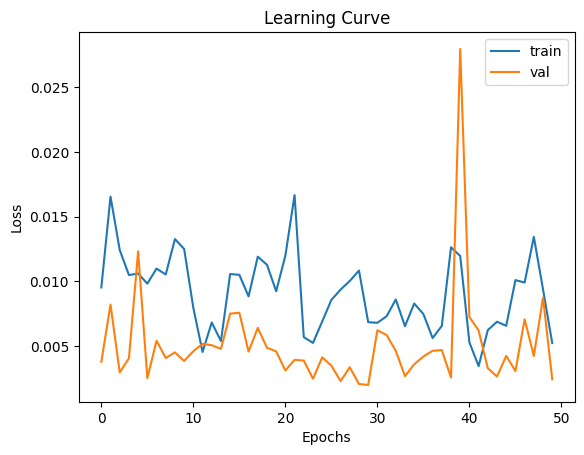

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()